In [1]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/TAB_Betting_Data.csv')

df['DATE_DIM'] = pd.to_datetime(df['DATE_DIM'])

df.fillna(0, inplace=True)

daily_df = df.groupby('DATE_DIM').agg({
    'TOTAL_TURNOVER': 'sum',
    'FOB_RACING_TURNOVER': 'sum',
    'FOB_SPORT_TURNOVER': 'sum',
    'PARI_RACING_TURNOVER': 'sum',
    'PARI_SPORT_TURNOVER': 'sum',
}).reset_index()

print(daily_df)

      DATE_DIM  TOTAL_TURNOVER  FOB_RACING_TURNOVER  FOB_SPORT_TURNOVER  \
0   2021-01-01      3835763.01           1740348.55           160299.45   
1   2021-01-02      6165935.03           3329808.95           257613.55   
2   2021-01-03      2198013.19            930629.79           331455.71   
3   2021-01-04      1523612.17            586816.57           321698.43   
4   2021-01-05      1480832.82            602373.79           224912.71   
..         ...             ...                  ...                 ...   
725 2022-12-27      2413850.20           1144594.00           311997.79   
726 2022-12-28      3379823.57           1741946.50           259758.31   
727 2022-12-29      2862803.99           1491770.50           284268.77   
728 2022-12-30      3000204.42           1543413.50           304666.43   
729 2022-12-31      5807930.20           3503842.50           367773.25   

     PARI_RACING_TURNOVER  PARI_SPORT_TURNOVER  
0              1935115.01                  0.0  
1

In [2]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.0 MB/s eta 0:00:00


ADF Statistic: -2.758614127284644
p-value: 0.06443293658201696


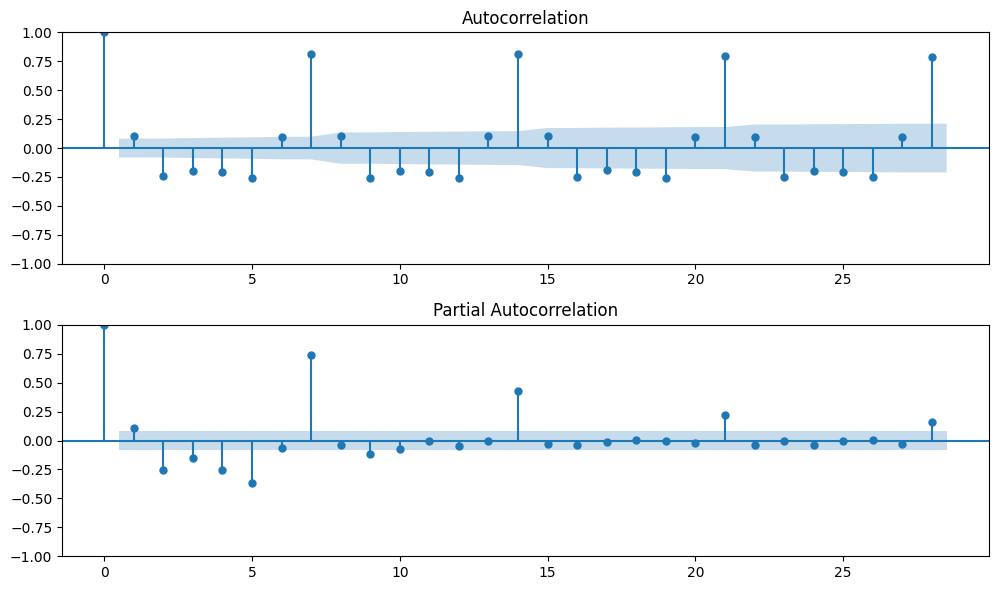

In [4]:
# 1. Check for Stationarity with the Augmented Dickey-Fuller test
# And Plot the ACF, PACF
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

adf_test_result = adfuller(daily_df['TOTAL_TURNOVER'])
print(f'ADF Statistic: {adf_test_result[0]}')
print(f'p-value: {adf_test_result[1]}')

daily_df.reset_index(inplace=True)
daily_df.set_index('DATE_DIM', inplace=True)

split_idx = int(len(daily_df) * 0.80)

# Split the data
train_data = daily_df.iloc[:split_idx]
test_data = daily_df.iloc[split_idx:]

# Plot ACF and PACF for the training data
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(train_data['TOTAL_TURNOVER'], ax=axes[0])
plot_pacf(train_data['TOTAL_TURNOVER'], ax=axes[1])
plt.tight_layout()

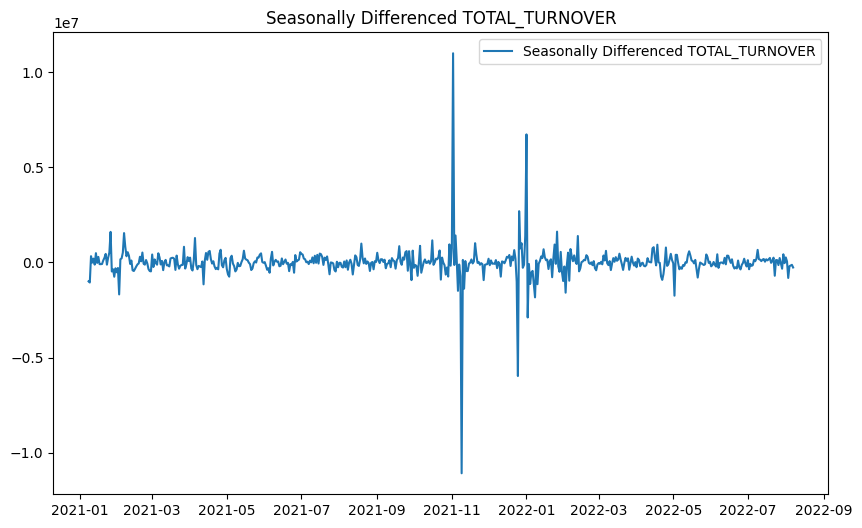

In [5]:
# 2. Perform Seasonal Differencing

seasonal_periods = 7

# Perform seasonal differencing
train_data_diff = train_data['TOTAL_TURNOVER'].diff(periods=seasonal_periods).dropna()

plt.figure(figsize=(10, 6))
plt.plot(train_data_diff, label='Seasonally Differenced TOTAL_TURNOVER')
plt.title('Seasonally Differenced TOTAL_TURNOVER')
plt.legend()
plt.show()

ADF Statistic: -10.501997196943389
p-value: 1.0780152257030106e-18


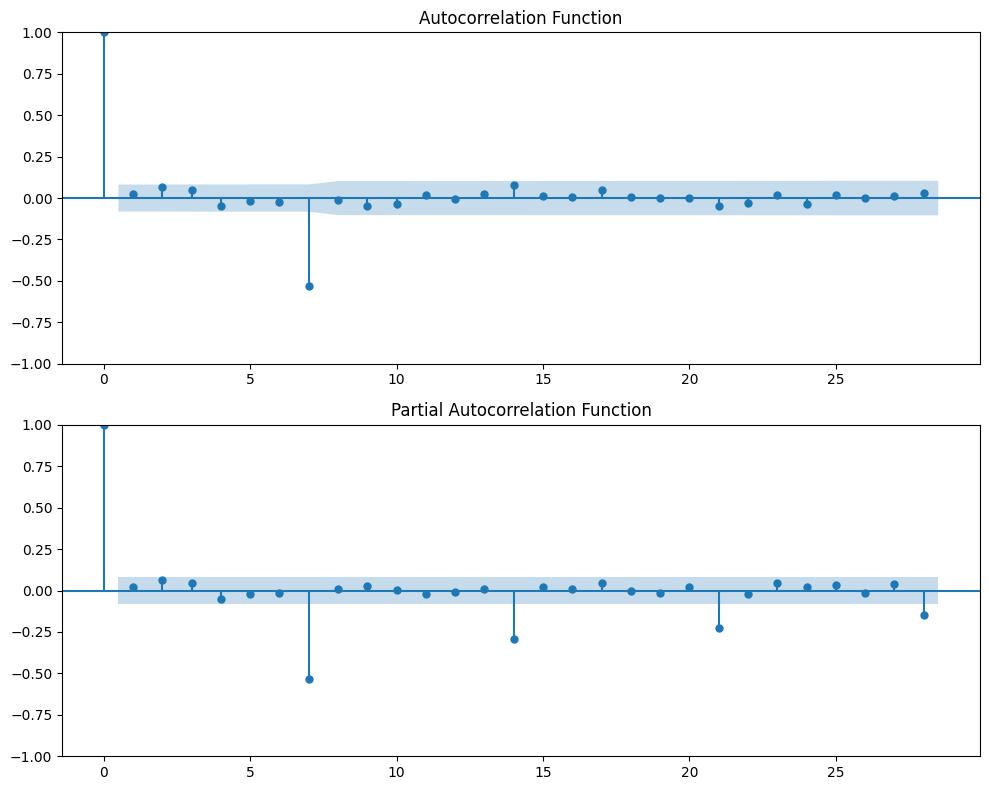

In [6]:
# 3. Check for Stationarity, plot ACF PACF of Differenced Data
from statsmodels.tsa.stattools import adfuller
adf_test_result = adfuller(train_data_diff)
print(f'ADF Statistic: {adf_test_result[0]}')
print(f'p-value: {adf_test_result[1]}')

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(train_data_diff, ax=axes[0])
axes[0].set_title('Autocorrelation Function')

plot_pacf(train_data_diff, ax=axes[1], method='ywm')
axes[1].set_title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()


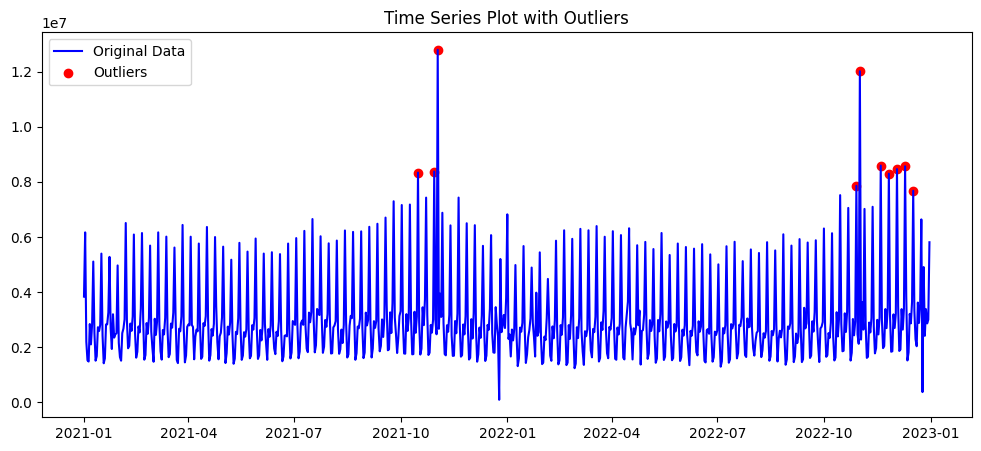

In [7]:
# 4. Outlier Detection and Treatment
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
z_scores = np.abs(stats.zscore(daily_df['TOTAL_TURNOVER']))
outliers_indices = np.where(z_scores > 3)
#Visualization
plt.figure(figsize=(12, 5))
plt.plot(daily_df['TOTAL_TURNOVER'], label='Original Data', color='blue')
plt.scatter(daily_df.iloc[outliers_indices]['TOTAL_TURNOVER'].index,
            daily_df.iloc[outliers_indices]['TOTAL_TURNOVER'],
            label='Outliers', color='red', marker='o')
plt.title('Time Series Plot with Outliers')
plt.legend()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[7] intercept   : AIC=17198.137, Time=5.34 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=17426.734, Time=0.14 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=17278.569, Time=1.00 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=17213.004, Time=1.32 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=17424.780, Time=0.06 sec
 ARIMA(2,0,2)(0,1,1)[7] intercept   : AIC=17196.134, Time=6.21 sec
 ARIMA(2,0,2)(0,1,0)[7] intercept   : AIC=inf, Time=3.90 sec
 ARIMA(2,0,2)(0,1,2)[7] intercept   : AIC=17198.135, Time=3.24 sec
 ARIMA(2,0,2)(1,1,0)[7] intercept   : AIC=inf, Time=6.32 sec
 ARIMA(2,0,2)(1,1,2)[7] intercept   : AIC=17199.008, Time=6.99 sec
 ARIMA(1,0,2)(0,1,1)[7] intercept   : AIC=17194.225, Time=1.62 sec
 ARIMA(1,0,2)(0,1,0)[7] intercept   : AIC=17430.562, Time=0.49 sec
 ARIMA(1,0,2)(1,1,1)[7] intercept   : AIC=17196.175, Time=5.13 sec
 ARIMA(1,0,2)(0,1,2)[7] intercept   : AIC=17196.199, Time=3.39 sec
 ARIMA(1,0,2)(1,1,0)[7] interce

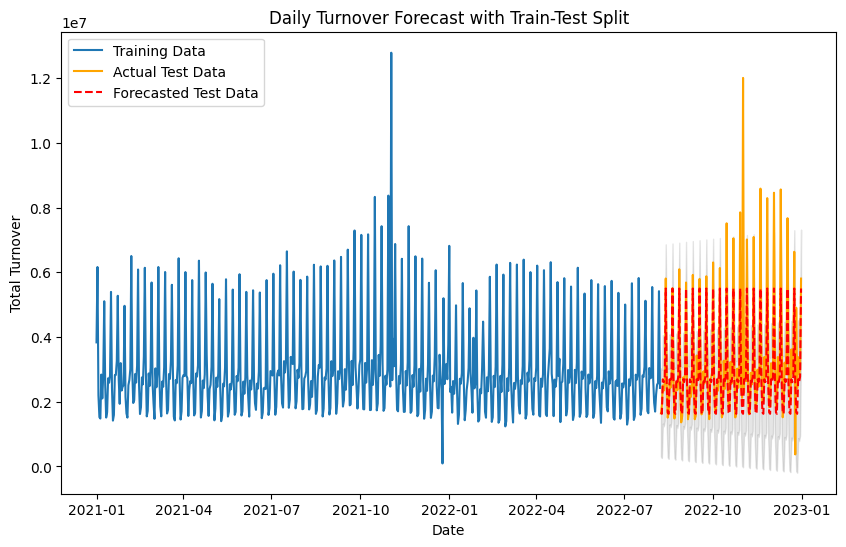

In [ ]:
# 4. Fit Auto ARIMA Model on training data
auto_arima_model = auto_arima(train_data['TOTAL_TURNOVER'], seasonal=True, m=7, D=1, stepwise=True, suppress_warnings=True, error_action="ignore", max_order=None, trace=True)
print(auto_arima_model.summary())

# Forecasting for the length of the test data
n_periods = len(test_data)
forecast, conf_int = auto_arima_model.predict(n_periods=n_periods, return_conf_int=True)
mae = mean_absolute_error(test_data['TOTAL_TURNOVER'], forecast)
rmse = np.sqrt(mean_squared_error(test_data['TOTAL_TURNOVER'], forecast))
print(f'MAE: {mae}, RMSE: {rmse}')

# Plotting the forecast
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['TOTAL_TURNOVER'], label='Training Data')
plt.plot(test_data.index, test_data['TOTAL_TURNOVER'], label='Actual Test Data', color='orange')
plt.plot(test_data.index, forecast, label='Forecasted Test Data', linestyle='--', color='red')
plt.fill_between(test_data.index, conf_int[:, 0], conf_int[:, 1], color='k', alpha=0.1)
plt.title('Daily Turnover Forecast with Train-Test Split')
plt.xlabel('Date')
plt.ylabel('Total Turnover')
plt.legend()
plt.show()